In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../')
import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import sys
sys.path.insert(0, '../../../rb_utils/')
sys.path.insert(0, '../../rb_utils/')
import common_utils 

# Load data

In [3]:
data_dir = '../mnist_data/'
propn_sample = 0.001

In [4]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [5]:
batchsize = 12

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [7]:
slen = data_train['image'].shape[-1]

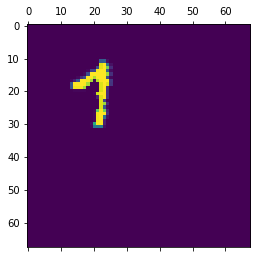

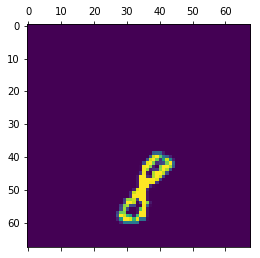

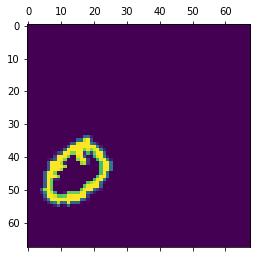

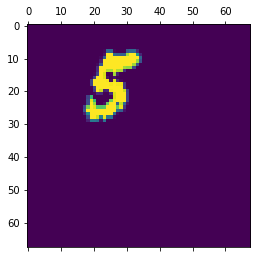

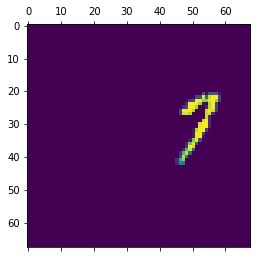

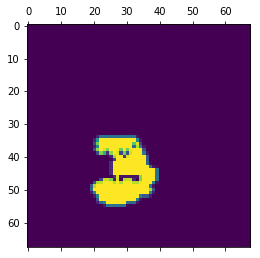

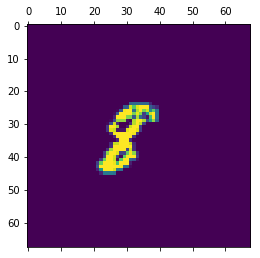

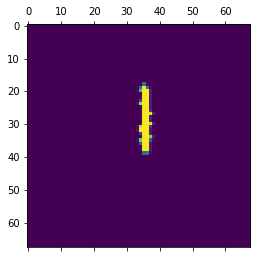

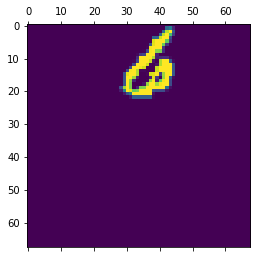

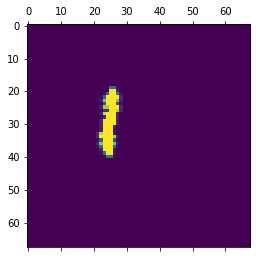

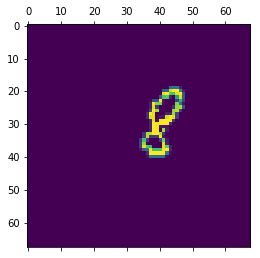

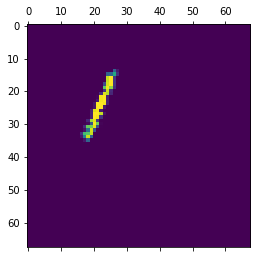

In [8]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [9]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [10]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [11]:
# Check padding and cropping functions

In [12]:
full_slen = image.shape[-1]

pixel_1d = pixel_2d[:, 1] * 68 + pixel_2d[:, 0]

one_hot_pixel = common_utils.get_one_hot_encoding_from_int(pixel_1d, full_slen**2)

In [13]:

cropped_images = moving_mnist_vae.crop_image(one_hot_pixel, image)

In [14]:
repadded_images = moving_mnist_vae.pad_image(cropped_images, one_hot_pixel)

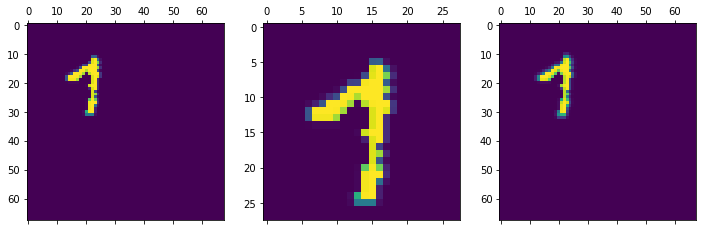

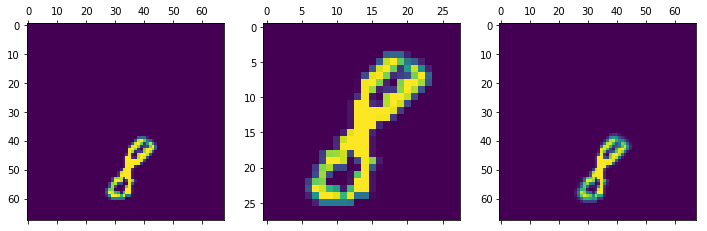

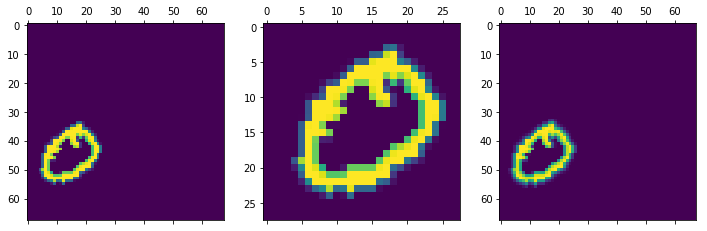

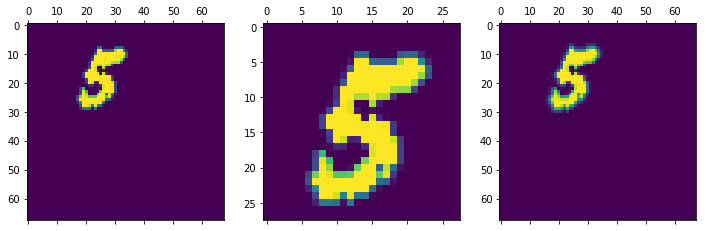

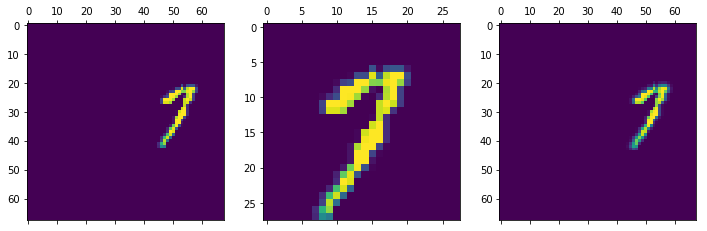

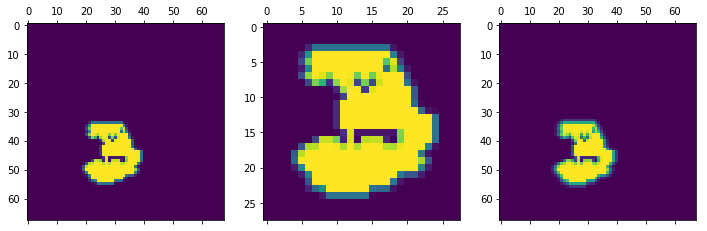

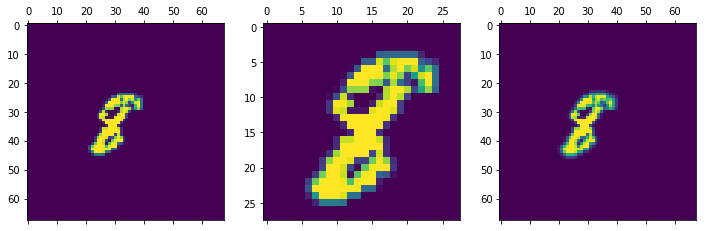

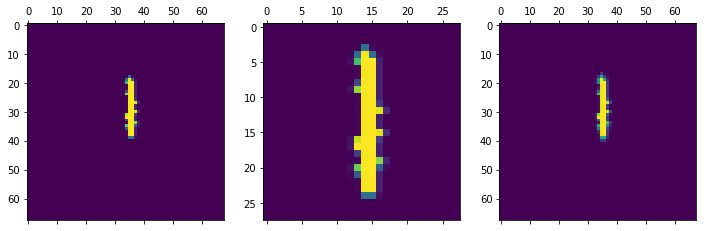

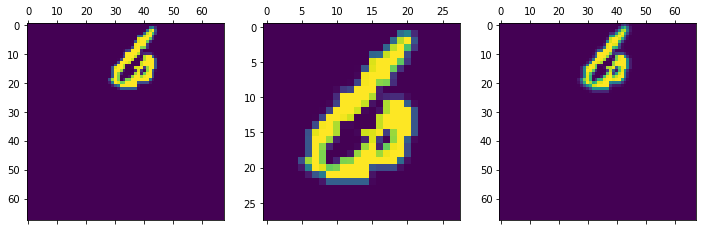

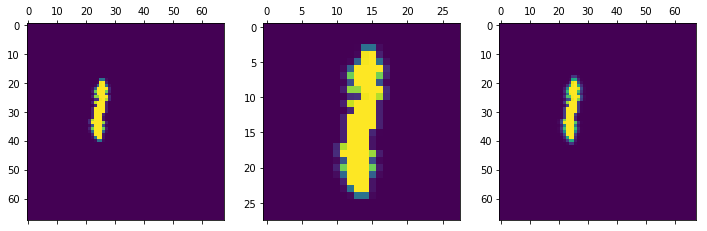

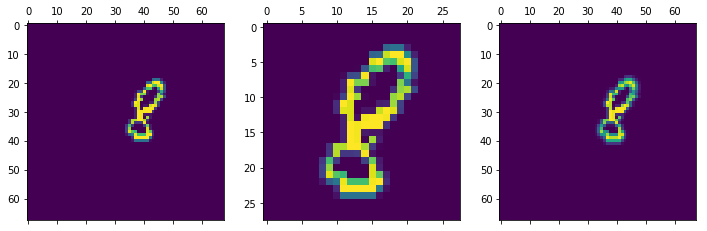

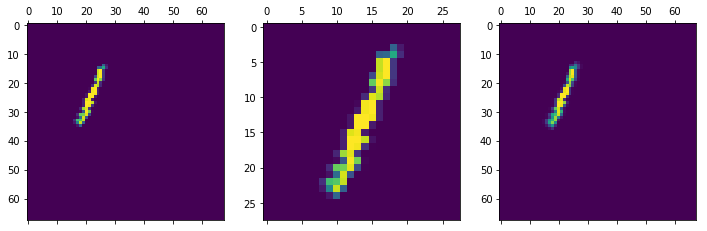

In [15]:
for i in range(batchsize): 
        
    _, axarr = plt.subplots(1, 3, figsize=(12, 12))
    
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(cropped_images[i, 0, :, :])
    axarr[2].matshow(repadded_images[i, 0, :, :])

In [16]:
image.shape

torch.Size([12, 1, 68, 68])

In [17]:
cropped_images.shape

torch.Size([12, 1, 28, 28])

In [18]:
repadded_images.shape

torch.Size([12, 1, 68, 68])

# Check training goes through

In [19]:
import baselines_lib as bs_lib

In [20]:
weight_decay = 1e-6
lr = 0.001

optimizer = optim.Adam([
                {'params': moving_mnist_vae.parameters(),
                'lr': lr,
                'weight_decay': weight_decay}])

grad_estimator = bs_lib.relax

In [21]:
grad_estimator = bs_lib.relax
temperature_param = torch.Tensor([1]).to(device).requires_grad_(True)
c_phi = bs_lib.RELAXBaseline(slen**2).to(device)
grad_estimator_kwargs = {'temperature': temperature_param,
                        'eta': 1.0,
                        'c_phi': c_phi}

bs_optimizer = optim.Adam([{'params': [temperature_param]},
                            {'params': c_phi.parameters()}], lr = 1e-2)


In [22]:
moving_mnist_vae.get_rb_loss(image,
                        grad_estimator,
                        grad_estimator_kwargs = grad_estimator_kwargs,
                        epoch = None,
                        topk = 0,
                        n_samples = 1,
                        true_pixel_2d = None)

(tensor(24291.3789, grad_fn=<AddBackward0>),
 tensor(26455.3047, grad_fn=<SumBackward0>))

In [23]:
vae_training_lib.eval_vae(moving_mnist_vae, train_loader, \
                grad_estimator,
                grad_estimator_kwargs = grad_estimator_kwargs,
                optimizer = None,
                train = False,
                set_true_loc = False,
                topk = 0,
                n_samples = 1,
                epoch = 0, 
                baseline_optimizer = bs_optimizer)

tensor(2442.6672)

In [ ]:
vae_training_lib.train_vae(moving_mnist_vae, train_loader, test_loader, optimizer, 
                grad_estimator = bs_lib.relax, 
                grad_estimator_kwargs = grad_estimator_kwargs, 
                outfile = '../mnist_vae_results/test',
                n_epoch = 5, print_every = 2, save_every = 2, topk = 5,
                set_true_loc = True, 
                baseline_optimizer = bs_optimizer)

In [ ]:
np.load('./mnist_vae_results/test_test_losses.npy')